# Data Cleaning

## About the Data:

The dataset is named GTZAN and it consist of 1000 audio files, 100 files for 10 genres each

### Genres in the dataset
1. Blues
2. Classical
3. Country
4. Pop
5. Hip-Hop
6. Rock
7. Jazz
8. reggae
9. Disco
10. Metal


## Data Directory Structure

In [1]:
import os 

path = os.path.join('Training_Audio_Data', 'GTZAN_Dataset')
for dirname, dirs, _ in os.walk(path):
  print(dirname)
  for dir in dirs:
    print(' '*3+ '-' + dir)
  break

GTZAN_Dataset
   -classical
   -disco
   -jazz
   -country
   -blues
   -pop
   -reggae
   -hiphop
   -rock
   -metal


## Initial File Check

Checking the integrity of the audio files by dump loading them using librosa

In [2]:
#Loading every audio_file
import librosa 
import warnings
warnings.filterwarnings("ignore")

Corrupted_files = []
count_ok = 0
count_corrupt = 0
for dirname, dirs, files in os.walk(path):
  for audio_fn in files:
    audio_path = os.path.join(dirname, audio_fn)
    try:
      audio_lb, sr = librosa.load(audio_path)
      count_ok += 1
    except:
      Corrupted_files.append(audio_fn)
      count_corrupt += 1

print(f'Loaded a Total of {count_ok} audio file(s) correctly')
print(f'Failed Loading a Total of {count_corrupt} audio file(s) correctly')
if count_corrupt:
  print('The Corrupted File(s) are:')
  for i ,fl in enumerate(Corrupted_files):
    print(f'{i+1}. {fl}')


Loaded a Total of 1000 audio file(s) correctly
Failed Loading a Total of 0 audio file(s) correctly


#### Remarks

All files are fine and can be loaded using librosa

## Audio Quality Check(Distorsion)
Checking all the original files for distorsion in the audio. 
The measure of Flatness will be used to compare distorsion

In [3]:
import librosa #Audio Analysis Library
import numpy as np
import re

#Dictionary to hold name of the genre and their corresponding measure of flatness
flatness = {'Genre': [], 'Flatness' : []}

#Going through each file
for dirname, dirs, files in os.walk(path):
  for audio_fn in files:
    audio_path = os.path.join(dirname, audio_fn)
    audio_lb, sr = librosa.load(audio_path)
    
    #Taking name of the file
    flatness['Genre'].append(re.search(r'([a-z]*)\.', audio_fn).group(1))
    #Calculating and storing Flatness
    flatness['Flatness'].append(np.mean(librosa.feature.spectral_flatness(audio_lb)))

## Visualizing Flatness Data

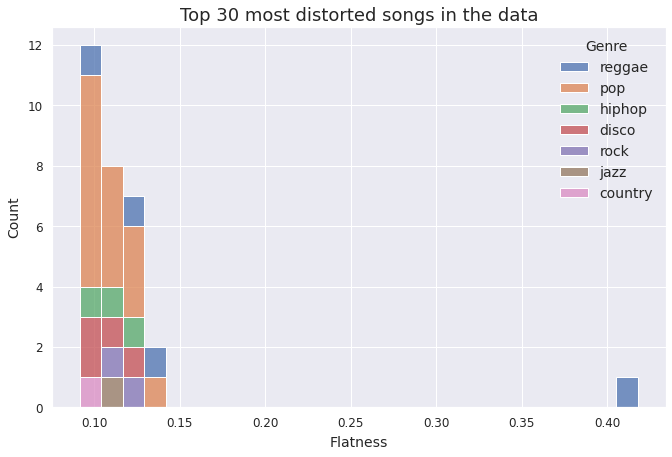

In [4]:
from matplotlib.transforms import Bbox
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Flatness DataFrame
data = pd.DataFrame(flatness).sort_values(by = 'Flatness', ascending=False).reset_index(drop=True)

#Plot
plt.figure(figsize=(11,7))
#Plot Properties
sns.set(rc={"axes.grid":True,'xtick.labelsize':12,'ytick.labelsize':12, 'axes.labelsize':14, 'axes.labelpad':6,
            'legend.frameon':False, 'legend.fontsize':14, 'legend.title_fontsize': 14})
#Histplot for top 30 songs with the most distorsion
sns.histplot(data = data.head(30), x = 'Flatness', hue = 'Genre', multiple = 'stack', ax = plt.gca())
plt.title('Top 30 most distorted songs in the data',fontsize=18)

#Saving
path = os.path.join('Visualization', 'Distorsion.png')
plt.savefig(path, bbox_inches='tight',dpi=200)

#### **Remarks**  

Mostly all songs have less than 0.15 Flatness, which is ok for all analyses purposes but some songs in the genre reggae have a flatness of more than 0.4. We have to identify that songs and remove it from the data set before any meaningfull analysis 

### Isolating Reggae Songs

In [5]:
flatness_reggae = {'File_Name': [], 'Flatness' : []}

#Going through each file
path = os.path.join('Training_Audio_Data', 'GTZAN_Dataset')
for dirname, dirs, files in os.walk(path):
  #Filtering for reggae
  if os.path.split(dirname)[-1] != 'reggae':
    continue
  for audio_fn in files:
    audio_path = os.path.join(dirname, audio_fn)
    audio_lb, sr = librosa.load(audio_path)
    
    #Taking name of the file
    flatness_reggae['File_Name'].append(audio_fn)
    #Calculating and storing Flatness
    flatness_reggae['Flatness'].append(np.mean(librosa.feature.spectral_flatness(audio_lb)))

In [6]:
data = pd.DataFrame(flatness_reggae).sort_values(by = 'Flatness', ascending=False).reset_index(drop=True)

#Most distorted songs in reggae
data.head(10)

,File_Name,Flatness
0,reggae.00086.wav,0.417805
1,reggae.00051.wav,0.131716
2,reggae.00045.wav,0.124056
3,reggae.00088.wav,0.103404
4,reggae.00050.wav,0.090270
5,reggae.00072.wav,0.065526
6,reggae.00052.wav,0.060917
7,reggae.00087.wav,0.059775
8,reggae.00079.wav,0.056940
9,reggae.00071.wav,0.050336


We have to remove reggae.00086.wav, Since it has high distorsion

In [7]:
audio_to_del = data.iloc[0,0]
path = os.path.join('Training_Audio_Data', 'GTZAN_Dataset','reggae',audio_to_del)
os.remove(path)

### Remakrs
Now Since the both the Integrity and Audio Quality have been tested we can move to Feature Engineering